# Table Segmentation Training

This notebook shows how to train a table segmentation model on the **SegmentedTables** dataset. You can download the model weights at https://github.com/paperswithcode/axcell/releases/download/v1.0/models.tar.xz.

In [1]:
from axcell.helpers.datasets import read_tables_annotations
from pathlib import Path

V1_URL = 'https://github.com/paperswithcode/axcell/releases/download/v1.0/'
SEGMENTED_TABLES_URL = V1_URL + 'segmented-tables.json.xz'

segmented_tables_annotations = read_tables_annotations(SEGMENTED_TABLES_URL)

In [2]:
from axcell.data.paper_collection import PaperCollection

SEGMENTED_TABLES_PAPERS = Path('/mnt/efs/pwc/data/arxiv/sources/segmented-tables/papers')
pc = PaperCollection.from_files(SEGMENTED_TABLES_PAPERS, annotations=segmented_tables_annotations.to_dict(orient='record'))

We convert papers and annotations into a dataframe with features: for each cell we get its content, row and column contexts, styles, references, etc. Additionally we query the elasticsearch instance with cell's content as query to search in a given paper for text fragments with this content. (Run `docker-compose up -d` from the `axcell` repository to start an elasticsearch instance.) We first ensure that all papers from `pc` are stored in the instance:

In [3]:
from axcell.data.structure import CellEvidenceExtractor

cell_evidences = CellEvidenceExtractor() # sets up elasticsearch connection on creation
for paper in pc:
    paper.text.save()

In [4]:
from joblib import delayed, Parallel
                
def process_single(index):
    cell_evidences = CellEvidenceExtractor()
    paper = pc[index]
    leaderboards = [table for table in paper.tables if 'leaderboard' in table.gold_tags.split(',')]
    evidences = cell_evidences(paper, leaderboards, paper_limit=30, corpus_limit=0)
    evidences['fold'] = paper.gold_tags
    evidences.header.fillna('', inplace=True)
    return evidences

In [5]:
%%time

evidences = Parallel(backend='multiprocessing', n_jobs=-1)(delayed(process_single)(index) for index in range(len(pc)))

CPU times: user 1.46 s, sys: 284 ms, total: 1.74 s
Wall time: 3min 16s


In [6]:
import pandas as pd
evidences = pd.concat(evidences)

In [7]:
evidences.to_pickle('/mnt/efs/pwc/data/arxiv/sources/segmented-tables/cell_evidences.pkl')

In [18]:
import pandas as pd
import re
from collections import OrderedDict
from fastai.text import *
from axcell.models.structure.structure_predictor import TableStructurePredictor


# make sure the training dataframe is batch_size aligned
def align_df(df, batch_size):
    aligned_len = ( len(df) // batch_size ) * batch_size
    return df.iloc[:aligned_len]


def dataframes_to_databunch(base_path, train_df, valid_df, test_df, batch_size, processor):
    classes=range(6)
    columns = ["label", "text", "cell_reference", "cell_styles", "cell_layout", "cell_content", "row_context", "col_context"]
    text_cols=["cell_styles", "cell_layout", "text", "cell_content", "row_context", "col_context", "cell_reference"]
    train_df, valid_df, test_df = train_df[columns], valid_df[columns], test_df[columns]
    
    label_cols = ["label"]
    train_tl = TextList.from_df(train_df, base_path, cols=text_cols, processor=processor)
    valid_tl = TextList.from_df(valid_df, base_path, cols=text_cols, processor=processor)
    test_tl  = TextList.from_df(test_df,  base_path, cols=text_cols, processor=processor)
    
    src = ItemLists(base_path, train_tl, valid_tl)\
        .label_from_df(cols=label_cols)
    src.add_test(test_tl)
    
    data_clas = src.databunch(bs=batch_size)
    return data_clas

def get_databunch(experiment, df, processor):
    is_test = df.fold == experiment.test_split
    is_valid = df.fold == experiment.valid_split
    test_df_all = df[is_test].copy()
    valid_df_all = df[is_valid].copy()
    train_df_all = df[(~is_test) & (~is_valid)].copy()
    train_df_all, valid_df_all, test_df_all = experiment.transform_df(train_df_all, valid_df_all, test_df_all)

    train_df, train_df_num = TableStructurePredictor.keep_alphacells(train_df_all)
    valid_df, valid_df_num = TableStructurePredictor.keep_alphacells(valid_df_all)
    test_df, test_df_num = TableStructurePredictor.keep_alphacells(test_df_all)
    train_df = align_df(train_df, experiment.BS)

    data_clas = dataframes_to_databunch(BASE_DIR, train_df, valid_df, test_df, experiment.BS, processor)
    return train_df, valid_df, test_df, data_clas

In [19]:
from axcell.models.structure.experiment import experiments_grid
from axcell.models.structure.ulmfit_experiment import ULMFiTExperiment

EXPERIMENTS_DIR = './experiments/segmentation'
BASE_DIR = Path('./models')

processor = processor = SPProcessor(
    sp_model=BASE_DIR / 'tmp' / 'spm.model',
    sp_vocab=BASE_DIR / 'tmp' / 'spm.vocab',
    mark_fields=True
)


experiment = ULMFiTExperiment(remove_num=False, drop_duplicates=False,
    this_paper=True, merge_fragments=True, merge_type='concat',
    evidence_source='text_highlited', split_btags=True, fixed_tokenizer=True,
    fixed_this_paper=True, mask=True, evidence_limit=None, context_tokens=None,
    lowercase=True, drop_mult=0.15, fp16=True, train_on_easy=False,
    dataset="segmented-tables",
    test_split='img_class',
    valid_split='speech_rec',
    pretrained_lm='lm'
)

In [20]:
train_df, valid_df, test_df, data_clas = get_databunch(experiment, evidences, processor)
model = experiment.get_trained_model(data_clas)
experiment.evaluate(model, train_df, valid_df, test_df)

train dataset
 * accuracy: 0.996
 * μ-precision: 0.995
 * μ-recall: 1.000
valid dataset
 * accuracy: 0.688
 * μ-precision: 0.630
 * μ-recall: 0.982
test dataset
 * accuracy: 0.817
 * μ-precision: 0.871
 * μ-recall: 0.876


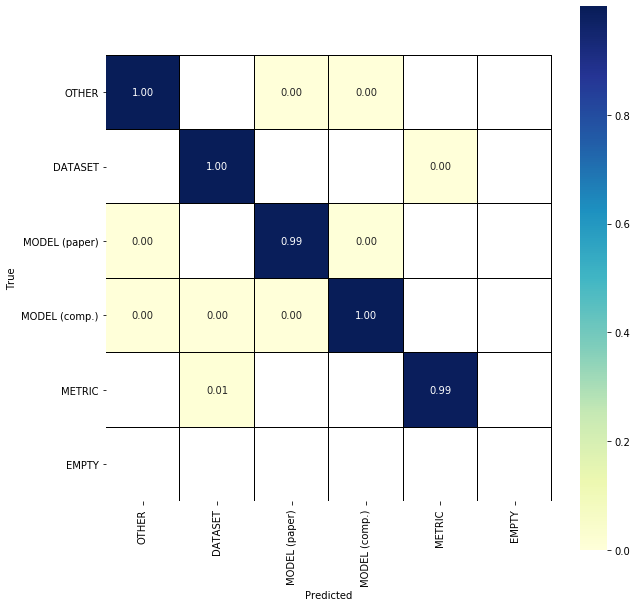

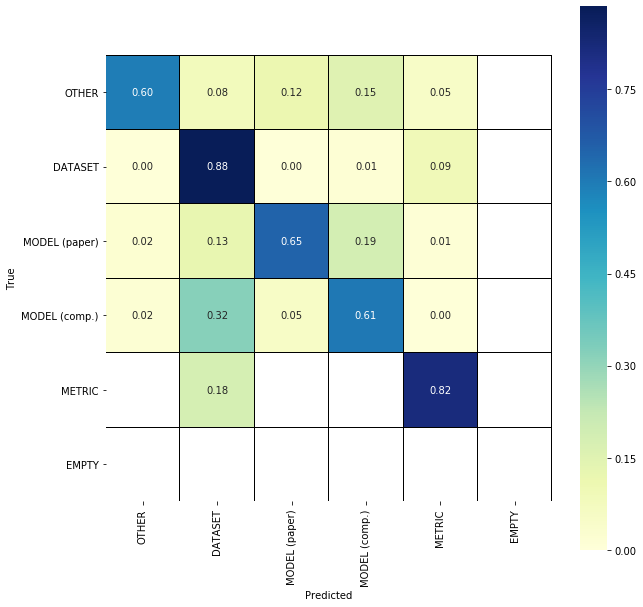

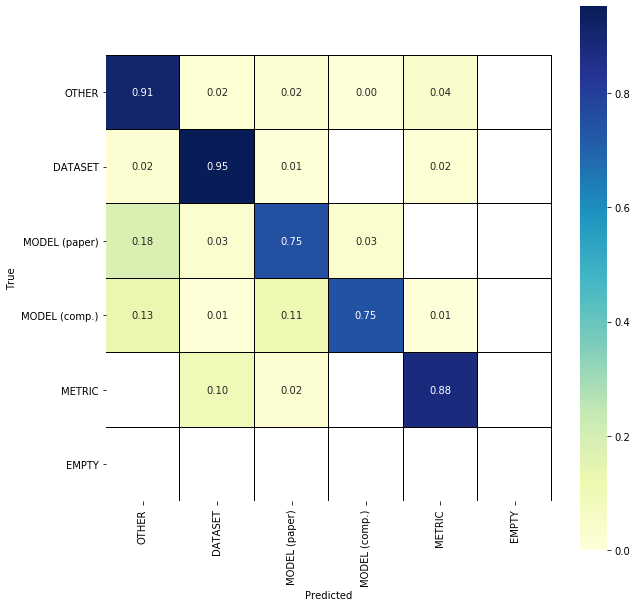

In [22]:
experiment.show_results(full_cm=False)